In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import *
from sklearn.model_selection import *
from sklearn.feature_selection import SelectKBest,f_classif
from datetime import datetime
import time

In [2]:
# 读取文件
tag=pd.read_csv("tag.csv")
trd=pd.read_csv("tradition.csv")
beh=pd.read_csv("behavior.csv")

# 一、EDA

In [3]:
# tag数据
tag.info()
# trd数据
trd.info()
# beh数据
beh.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39923 entries, 0 to 39922
Data columns (total 43 columns):
id                                 39923 non-null object
flag                               39923 non-null int64
gdr_cd                             39923 non-null object
age                                39923 non-null int64
mrg_situ_cd                        39923 non-null object
edu_deg_cd                         27487 non-null object
acdm_deg_cd                        39922 non-null object
deg_cd                             18960 non-null object
job_year                           39923 non-null object
ic_ind                             39923 non-null object
fr_or_sh_ind                       39923 non-null object
dnl_mbl_bnk_ind                    39923 non-null object
dnl_bind_cmb_lif_ind               39923 non-null object
hav_car_grp_ind                    39923 non-null object
hav_hou_grp_ind                    39923 non-null object
l6mon_agn_ind                      399

In [4]:
total=tag.shape[0]
tradition_total=trd.groupby('id').count().shape[0]
behavior_total=beh.groupby('id').count().shape[0]
print(total)
print(tradition_total/total) # 大概80%的用户有交易记录
print(behavior_total/total) # 仅有大约30%的用户有APP行为数据

39923
0.8013676326929339
0.2983994188813466


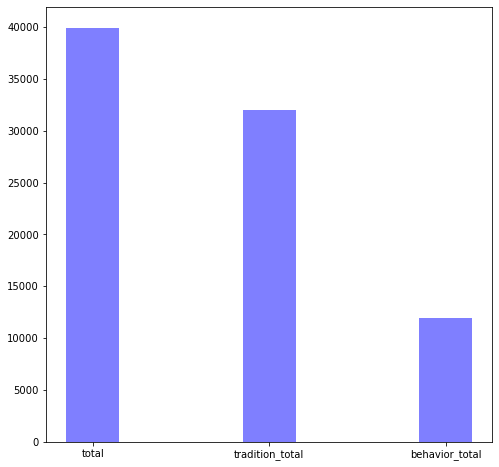

In [6]:
x=['total','tradition_total','behavior_total']
y=[total,tradition_total,behavior_total]
plt.figure(figsize=(8,8))
plt.bar(x,y,width=0.3,alpha=0.5,color='blue')
plt.show()

# 二、数据预处理

## 1. tag表

In [7]:
# train_tag=pd.read_csv("tag.csv")
tag=pd.read_csv("tag.csv")
# test_tag=pd.read_csv("test_tag.csv")
tag.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39923 entries, 0 to 39922
Data columns (total 43 columns):
id                                 39923 non-null object
flag                               39923 non-null int64
gdr_cd                             39923 non-null object
age                                39923 non-null int64
mrg_situ_cd                        39923 non-null object
edu_deg_cd                         27487 non-null object
acdm_deg_cd                        39922 non-null object
deg_cd                             18960 non-null object
job_year                           39923 non-null object
ic_ind                             39923 non-null object
fr_or_sh_ind                       39923 non-null object
dnl_mbl_bnk_ind                    39923 non-null object
dnl_bind_cmb_lif_ind               39923 non-null object
hav_car_grp_ind                    39923 non-null object
hav_hou_grp_ind                    39923 non-null object
l6mon_agn_ind                      399

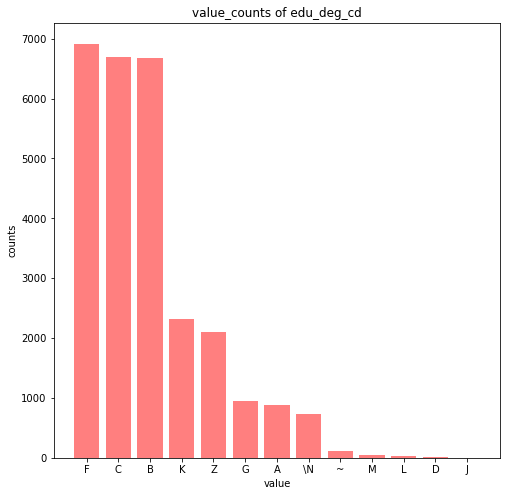

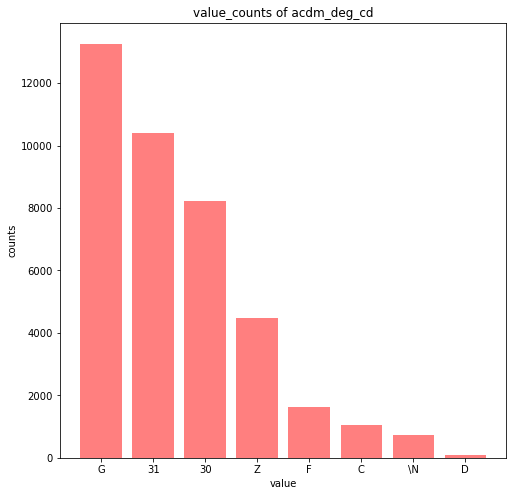

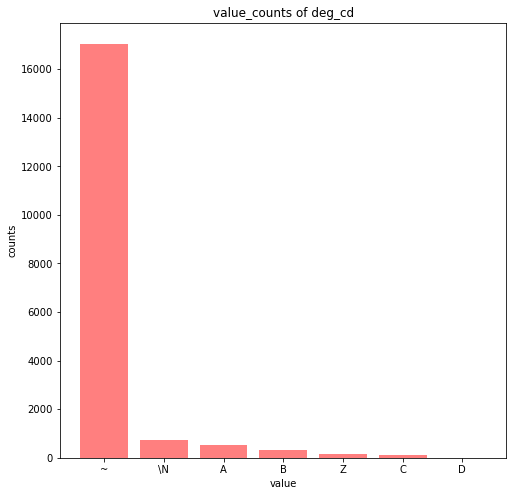

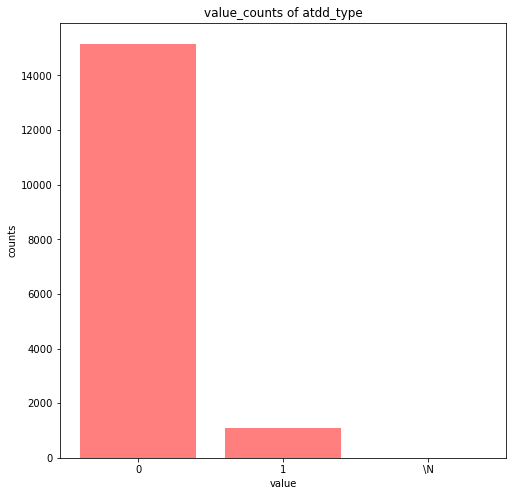

In [8]:
# 用柱状图统计各个特征情况
def feature_bar(feature,data,figsize=(8,8)): 
    feat_data=data[feature].value_counts()
    plt.figure(figsize=figsize)
    plt.bar(feat_data.index.values,feat_data.values,color='red',alpha=0.5)
    plt.title('value_counts of '+feature)
    plt.ylabel('counts')
    plt.xlabel('value')
    plt.show()
feature_bar('edu_deg_cd',tag)
feature_bar('acdm_deg_cd',tag)
feature_bar('deg_cd',tag)
feature_bar('atdd_type',tag)

In [81]:
# 对年龄段做分桶
bins=[i*10 for i in range(1,10)]
group_names=['[10,20)','[20,30)','[30,40)','[40,50)','[50,60)','[60,70)','[70,80)','[80,90]']
catagories=pd.cut(tag['age'],bins,labels=group_names)
tag['age']=catagories

In [82]:
# 查看有缺失值的字段的情况
print(tag['edu_deg_cd'].value_counts())
print(tag['acdm_deg_cd'].value_counts())
print(tag['deg_cd'].value_counts())
print(tag['atdd_type'].value_counts())

# 缺失值与\N、~字段并不是等价的，可以考虑将这些当做新的种类
# 其中\N字段基本相同，所以可能会因为缺失值补充造成分布比例变化
# 所以有~的可以将缺失值补成~，只有\N的就补充\N
tag['edu_deg_cd'].fillna('~',inplace=True)
tag['acdm_deg_cd'].fillna(r'\N',inplace=True)
tag['deg_cd'].fillna('~',inplace=True)
tag['atdd_type'].fillna(r'\N',inplace=True)

F     6917
C     6695
B     6672
K     2312
Z     2097
G      953
A      889
\N     736
~      108
M       54
L       33
D       20
J        1
Name: edu_deg_cd, dtype: int64
G     13267
31    10419
30     8229
Z      4469
F      1635
C      1064
\N      736
D       103
Name: acdm_deg_cd, dtype: int64
~     17050
\N      736
A       543
B       332
Z       171
C       118
D        10
Name: deg_cd, dtype: int64
0     15162
1      1097
\N        7
Name: atdd_type, dtype: int64


In [83]:
# 其余特征根据实际情况进行类型转换
# 将int类型的特征的‘\N’进行处理，原则是不要干扰到原来的比例，将\N当做一个新的类型
# columns1将\N转成0是因为字段本身有特殊的一类-1，需要将\N与-1区分开来，故将其置为0
columns1=['frs_agn_dt_cnt','fin_rsk_ases_grd_cd','confirm_rsk_ases_lvl_typ_cd',
         'cust_inv_rsk_endu_lvl_cd','tot_ast_lvl_cd','pot_ast_lvl_cd','hld_crd_card_grd_cd']
for i in columns1:
    tag[i].replace({r'\N':0},inplace=True)
    # 转成int
    tag[i]=tag[i].astype(int)
    
# columns2将\N转成-1，思路其实一样，为了将\N与数据区分开来，字段里表示数字的含有0，故将\N转为-1
columns2=['job_year','l12mon_buy_fin_mng_whl_tms','l12_mon_fnd_buy_whl_tms','l12_mon_insu_buy_whl_tms',
          'l12_mon_gld_buy_whl_tms','ovd_30d_loan_tot_cnt','his_lng_ovd_day','l1y_crd_card_csm_amt_dlm_cd']
for i in columns2:
    tag[i].replace({r'\N':-1},inplace=True)
    # 转成int
    tag[i]=tag[i].astype(int)
    
# 转成str类型
columns3=['gdr_cd','mrg_situ_cd','edu_deg_cd','acdm_deg_cd','deg_cd','ic_ind','fr_or_sh_ind',
          'dnl_mbl_bnk_ind','dnl_bind_cmb_lif_ind','hav_car_grp_ind','hav_hou_grp_ind',
          'l6mon_agn_ind','vld_rsk_ases_ind','loan_act_ind','crd_card_act_ind','atdd_type','age']
for i in columns3:
    # 转成str
    tag[i]=tag[i].astype(str)

In [84]:
# 保存补充完后的数据，用于数据分析
# completed_tag = tag.iloc[:train_tag_row, :]
# completed_tag['flag']=labels.values
completed_tag=tag
completed_tag.to_csv("completed_tag.csv")

In [12]:
# # 训练集与测试集分开
# train_tag=tag.iloc[:train_tag_row,:]
# test_tag=tag.iloc[train_tag_row:,:]

## 2. tradition表

In [85]:
# train_trd=pd.read_csv("tradition.csv")
# test_trd=pd.read_csv("test_tradition.csv")
trd=pd.read_csv("tradition.csv")

In [86]:
# 合并训练集与测试集
# train_trd_row = train_trd.shape[0] # 训练集与测试集分界线
# 删除标签列
trd.drop(['flag'],axis=1,inplace=True)
# trd=pd.concat([train_trd, test_trd], axis = 0)

In [87]:
# 将交易时间trx_tm特征进行提取，提取出年月日周等信息
trd['date']=trd['trx_tm'].apply(lambda x: x[0:10])
trd['month']=trd['trx_tm'].apply(lambda x: int(x[5:7]))
trd['day_1']=trd['trx_tm'].apply(lambda x: int(x[8:10]))
trd['hour']=trd['trx_tm'].apply(lambda x: int(x[11:13]))
trd['trx_tm']=trd['trx_tm'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
trd['day']=trd['trx_tm'].apply(lambda x: x.dayofyear)
trd['weekday']=trd['trx_tm'].apply(lambda x: x.weekday())
trd['isWeekend']=trd['weekday'].apply(lambda x: 1 if x in [5, 6] else 0)
trd['trx_tm']=trd['trx_tm'].apply(lambda x: int(time.mktime(x.timetuple())))

In [88]:
# 保存补充完后的数据，用于数据分析
# completed_trd = trd.iloc[:train_trd_row, :]
completed_trd=trd
completed_trd.to_csv("completed_trd.csv")

In [17]:
# 对交易方向，支付方式以及收支分类代码进行one-hot编码
# columns=['Dat_Flg1_Cd','Dat_Flg3_Cd','Trx_Cod1_Cd','Trx_Cod2_Cd']
# for i in columns:
#     trd[i]=pd.get_dummies(trd[i],prefix=i,dummy_na=True)

In [18]:
# 训练集与测试集分开
# train_trd=trd.iloc[:train_trd_row,:]
# test_trd=trd.iloc[train_trd_row:,:]

# 三、特征提取

## 1. tradition表

### 按id进行特征提取，主要是F和M特征

In [89]:
# trd_id为trd基于id进行的特征提取结果
trd_id=trd[['id']].drop_duplicates().reset_index(drop=True)
trd.sort_values(by=['id','trx_tm'], ascending=True, inplace=True)

In [90]:
# 提取每个用户的交易总次数、天数以及金额
# 交易总次数
trd['count']=1
trd_count=trd.groupby('id')['count'].agg({'trd_count': 'sum'}).reset_index()
trd_id=pd.merge(trd_id,trd_count,how='left',on='id')
# 交易总天数
day_count=trd.groupby('id')['date'].agg({'day_count': 'nunique'}).reset_index()
trd_id=pd.merge(trd_id,day_count,how='left',on='id')
# 交易总金额
trd_amt=trd.groupby('id')['cny_trx_amt'].agg({'trd_amt': 'sum'}).reset_index()
trd_id=pd.merge(trd_id,trd_amt,how='left',on='id')

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  import sys
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  # Remove the CWD from sys.path while we load stuff.


In [91]:
# 平均每天交易次数、交易金额以及每次的平均交易金额
trd_id['avg_perday_trd_count']=trd_id['trd_count']/trd_id['day_count']
trd_id['avg_perday_trd_amt']=trd_id['trd_amt']/trd_id['day_count']
trd_id['avg_pertime_trd_amt']=trd_id['trd_amt']/trd_id['trd_count']

In [92]:
# 对其余交易方向、交易方式、一级二级代码、分别计总次数与平均每天次数
columns=['Dat_Flg1_Cd','Dat_Flg3_Cd','Trx_Cod1_Cd','Trx_Cod2_Cd']
for i in columns:
    total_count=trd.groupby(['id',i])['count'].agg({'sum'})
    total_count=total_count.unstack().reset_index()
    total_count.fillna(0,inplace=True)
    tmp=list(total_count.columns)
    tmp[0]='id'
    tmp[1:]=[i+'_trd_count_'+str(x[1]) for x in tmp[1:]]
    # 计算总次数
    total_count.columns=tmp
    trd_id=pd.merge(trd_id,total_count,how='left',on='id')
    # 平均每天次数
    for j in total_count.columns[1:]:
        trd_id[i+'_avg_perday_trd_count_'+j.split('_')[-1]]=trd_id[j]/trd_id['day_count']

In [93]:
# 对其余特征进行分别计金额数,平均每天金额数和平均每次金额数
for i in columns:
    total_amt=trd.groupby(['id',i])['cny_trx_amt'].agg({'sum'})
    total_amt=total_amt.unstack().reset_index()
    total_amt.fillna(0, inplace=True)
    tmp=list(total_amt.columns)
    tmp[0]='id'
    tmp[1:]=[i+'_amt_'+str(x[1]) for x in tmp[1:]]
    # 计算总金额
    total_amt.columns=tmp
    trd_id=pd.merge(trd_id,total_amt,how='left',on='id')
    # 平均每天的交易金额
    for j in total_amt.columns[1:]:
        # 平均每天金额数
        time.sleep(1)
        trd_id[i+'_avg_perday_trd_amt_'+j.split('_')[-1]]=trd_id[j]/trd_id['day_count']
        # 平均每次金额数
        trd_id[i+'_avg_pertime_trd_amt_'+j.split('_')[-1]]=trd_id[j]/trd_id[i+'_trd_count_'+j.split('_')[-1]]

In [94]:
# 保存文件用于数据分析
trd_id.to_csv("trd_id.csv")

### R特征提取（即最近一次交易时间，RFM模型中的R）

In [98]:
trd_R=trd[['id']].drop_duplicates().reset_index(drop=True)
trd.sort_values(by=['id','trx_tm'],ascending=True,inplace=True)
# day字段变成了与所有交易记录中最小值的差值
trd['day']=trd['day']-trd['day'].min()

In [99]:
# 计算每个id最后一次的交易时间
trd_latest=trd.groupby('id')['day'].agg({'trd_latest': 'max'}).reset_index()
# trd_latest['trd_latest']=60-trd_latest['trd_latest']
# 计算该id的最后一个交易时间是否晚于平均值，乘以1是为了将类型转为int而非object
trd_latest['over_trd_latest_mean']=(trd_latest['trd_latest']>trd_latest['trd_latest'].mean())*1
trd_R=pd.merge(trd_R,trd_latest,how='left',on='id')

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  


In [100]:
# 保存文件用于数据分析
trd_R.to_csv("trd_R.csv")

In [104]:
print(trd_R.info())
print(trd_id.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31993 entries, 0 to 31992
Data columns (total 3 columns):
id                      31993 non-null object
trd_latest              31993 non-null int64
over_trd_latest_mean    31993 non-null int32
dtypes: int32(1), int64(1), object(1)
memory usage: 874.8+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 31993 entries, 0 to 31992
Columns: 327 entries, id to Trx_Cod2_Cd_avg_pertime_trd_amt_311
dtypes: float64(324), int64(2), object(1)
memory usage: 80.1+ MB
None


## 2. 合并数据集处理

In [234]:
# 合并数据集，约有20%的人没有trd特征，所以约有20%的空值
data=pd.merge(tag,trd_id,how='left',on='id')
data.fillna(0,inplace=True)
data=pd.merge(data,trd_R,how='left',on='id')
data.fillna(-1,inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39923 entries, 0 to 39922
Columns: 371 entries, id to over_trd_latest_mean
dtypes: float64(328), int32(15), int64(10), object(18)
memory usage: 111.0+ MB


In [161]:
# 随机森林填补缺失值
from sklearn.ensemble import RandomForestRegressor
# 记录有缺失值的列
totalcolumns=trd_id.columns.tolist()+trd_R.columns.tolist()
cols=[]
for columnname in totalcolumns:
    if data[columnname].count()!=len(data):
         cols.append(columnname)

# 随机森林进行缺失值补充
def add_missing(data,col):
    temp=data.loc[:,[col,'l6mon_daim_aum_cd','bk1_cur_year_mon_avg_agn_amt_cd','pl_crd_lmt_cd','perm_crd_lmt_cd','cur_debit_cnt','cur_credit_cnt','cur_debit_min_opn_dt_cnt','cur_credit_min_opn_dt_cnt','cur_debit_crd_lvl']]
    know=temp[temp[col].notnull()].values
    unknow=temp[temp[col].isnull()].values
    Y=know[:,0]
    X=know[:,1:]
    RF=RandomForestRegressor(random_state=2017,n_estimators=200,max_depth=3,n_jobs=-1)
    RF.fit(X,Y)
    predicted=RF.predict(unknow[:,1:])
    data.loc[data[col].isnull(),col]=predicted
    return data

for col in cols:
    add_missing(data,col)

In [235]:
# 将str类型特征进行one-hot编码
columns3=['gdr_cd','mrg_situ_cd','edu_deg_cd','acdm_deg_cd','deg_cd','ic_ind','fr_or_sh_ind',
          'dnl_mbl_bnk_ind','dnl_bind_cmb_lif_ind','hav_car_grp_ind','hav_hou_grp_ind',
          'l6mon_agn_ind','vld_rsk_ases_ind','loan_act_ind','crd_card_act_ind','atdd_type','age']
for i in columns3:
    data[i]=pd.get_dummies(data[i],prefix=i,dummy_na=True)

# 四、特征选择

In [236]:
# 数据集整理
labels=data['flag'].values
data.drop(['flag'],axis=1,inplace=True)
identify=data['id'].values
data.drop(['id'],axis=1,inplace=True)

In [237]:
# 保留一次当前的data，因为后面想尝试删除部分特征缓和过拟合
data_new=data.copy()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39923 entries, 0 to 39922
Columns: 369 entries, gdr_cd to over_trd_latest_mean
dtypes: float64(328), int32(15), int64(9), uint8(17)
memory usage: 105.9 MB


D:\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [340] are constant.
  UserWarning)
D:\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


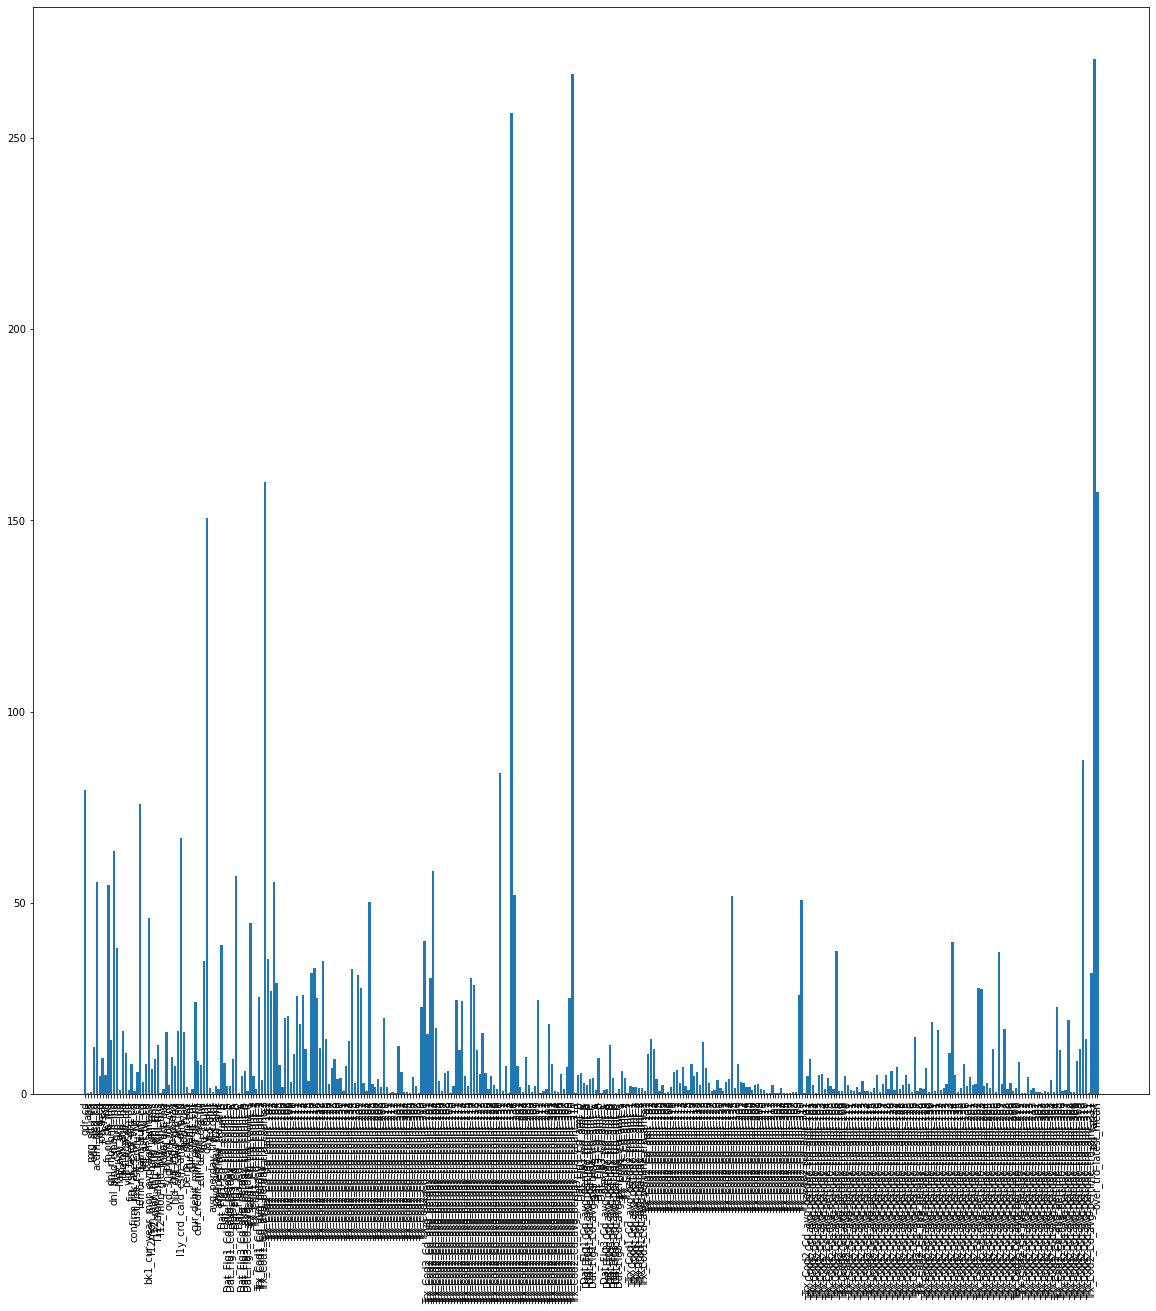

In [216]:
# 特征选择，选择top300个特征
selector=SelectKBest(f_classif,k=350)
select_features=selector.fit(data_new,labels).get_support(indices=True)
scores=-np.log10(selector.pvalues_)

# 打印出前50特征的分数
plt.figure(figsize=(20,20))
plt.bar(range(len(select_features)),scores[select_features])
plt.xticks(range(len(select_features)),data_new.columns[select_features],rotation='vertical')
plt.show()

In [217]:
# 留下310个特征，剩下的删除
# 创建待删除特征列表
delete_features=[]
for col in data_new.columns:
    if col not in data_new.columns[select_features]: 
        delete_features.append(col)

data_new.drop(delete_features,axis=1,inplace=True)

# 四、模型构建

In [238]:
# xgboost的sklearn接口
from sklearn.model_selection import train_test_split
from xgboost.sklearn import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection,metrics
import xgboost as xgb
from xgboost import plot_importance
RANDOM_STATE=2017

In [239]:
# 标准化数据集
X_scaler=StandardScaler()
data_new=X_scaler.fit_transform(data_new)

# 数据集转换成DMatrix
X_train,X_test,y_train,y_test=train_test_split(data_new,labels,test_size=0.2,random_state=RANDOM_STATE)
train_xgb=xgb.DMatrix(X_train,label=y_train)
test_xgb=xgb.DMatrix(X_test,label=y_test)

In [281]:
# sklearn接口
model=XGBClassifier(max_depth=6,#最大深度
                     learning_rate=0.01,#学习率为0.01
                     n_estimators=5000,#初始设为500，利用xgboost的cv函数确定值
                     silent=False,
                     objective='binary:logistic',#二分类逻辑回归，输出为预测概率
                     booster='gbtree',#基学习器
                     n_jobs=-1,#最大可用线程数
                     gamma=0,#指定了节点分裂所需的最小损失函数下降值，值越大越保守
                     min_child_weight=5,#子节点最小权重和，低于则不再划分
                     subsample=0.8,#抽取数据的比例
                     colsample_bytree=0.8,#列采样比例，采样特征
                     reg_lambda=1,#正则化参数
                     seed=RANDOM_STATE)#随机种子
model.get_xgb_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': 'gbtree',
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 0.8,
 'gamma': 0,
 'gpu_id': None,
 'importance_type': 'gain',
 'interaction_constraints': None,
 'learning_rate': 0.01,
 'max_delta_step': None,
 'max_depth': 6,
 'min_child_weight': 5,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 5000,
 'n_jobs': -1,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': 1,
 'scale_pos_weight': None,
 'subsample': 0.8,
 'tree_method': None,
 'validate_parameters': False,
 'verbosity': None,
 'silent': False,
 'seed': 2017}

In [120]:
# 训练模型
# modelfit=model.fit(X_train,y_train)

In [121]:
# plot_importance(modelfit)

## 1. 先确定训练器个数n_estimators

In [282]:
# 设置cv参数，利用cv函数来确定n_estimators训练器个数，训练得出是208效果最好
cv_result=xgb.cv(model.get_xgb_params(),
                   train_xgb,
                   num_boost_round=model.get_xgb_params()['n_estimators'],
                   nfold=5,
                   metrics='auc',
                   early_stopping_rounds=50,
                   callbacks=[xgb.callback.early_stop(50),
                              xgb.callback.print_evaluation(period=1,show_stdv=True)])

Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
[0]	train-auc:0.72506+0.00368	test-auc:0.70887+0.01133
[1]	train-auc:0.74292+0.00295	test-auc:0.72158+0.01054
[2]	train-auc:0.74999+0.00434	test-auc:0.72622+0.00763
[3]	train-auc:0.75385+0.00280	test-auc:0.73008+0.00667
[4]	train-auc:0.75595+0.00182	test-auc:0.73163+0.00682
[5]	train-auc:0.75834+0.00251	test-auc:0.73333+0.00727
[6]	train-auc:0.75948+0.00259	test-auc:0.73428+0.00728
[7]	train-auc:0.76059+0.00255	test-auc:0.73481+0.00726
[8]	train-auc:0.76106+0.00286	test-auc:0.73484+0.00730
[9]	train-auc:0.76107+0.00232	test-auc:0.73510+0.00800
[10]	train-auc:0.76180+0.00212	test-auc:0.73534+0.00763
[11]	train-auc:0.76246+0.00262	test-auc:0.73561+0.00755
[12]	train-auc:0.76316+0.00308	test-auc:0.73622+0.00789
[13]	train-auc:0.76352+0.00308	test-auc:0.73607+0.00750
[14]	train-auc:0.76398+0.00270	test-auc:0.73618+0.00733
[15]	train-auc:0.76452+0.0027

[144]	train-auc:0.79464+0.00136	test-auc:0.74740+0.00716
[145]	train-auc:0.79485+0.00136	test-auc:0.74736+0.00719
[146]	train-auc:0.79499+0.00133	test-auc:0.74742+0.00716
[147]	train-auc:0.79522+0.00133	test-auc:0.74751+0.00715
[148]	train-auc:0.79542+0.00136	test-auc:0.74758+0.00716
[149]	train-auc:0.79559+0.00142	test-auc:0.74760+0.00714
[150]	train-auc:0.79576+0.00139	test-auc:0.74766+0.00711
[151]	train-auc:0.79592+0.00138	test-auc:0.74768+0.00713
[152]	train-auc:0.79607+0.00137	test-auc:0.74777+0.00710
[153]	train-auc:0.79623+0.00141	test-auc:0.74788+0.00706
[154]	train-auc:0.79637+0.00142	test-auc:0.74795+0.00703
[155]	train-auc:0.79667+0.00138	test-auc:0.74792+0.00706
[156]	train-auc:0.79685+0.00134	test-auc:0.74797+0.00703
[157]	train-auc:0.79700+0.00130	test-auc:0.74805+0.00707
[158]	train-auc:0.79722+0.00126	test-auc:0.74808+0.00703
[159]	train-auc:0.79741+0.00124	test-auc:0.74814+0.00714
[160]	train-auc:0.79762+0.00121	test-auc:0.74816+0.00714
[161]	train-auc:0.79782+0.00121

[288]	train-auc:0.82202+0.00142	test-auc:0.75167+0.00728
[289]	train-auc:0.82219+0.00142	test-auc:0.75170+0.00727
[290]	train-auc:0.82234+0.00145	test-auc:0.75174+0.00725
[291]	train-auc:0.82248+0.00149	test-auc:0.75174+0.00727
[292]	train-auc:0.82262+0.00151	test-auc:0.75177+0.00727
[293]	train-auc:0.82277+0.00150	test-auc:0.75183+0.00730
[294]	train-auc:0.82296+0.00148	test-auc:0.75183+0.00730
[295]	train-auc:0.82313+0.00150	test-auc:0.75186+0.00727
[296]	train-auc:0.82332+0.00148	test-auc:0.75184+0.00729
[297]	train-auc:0.82345+0.00148	test-auc:0.75188+0.00733
[298]	train-auc:0.82361+0.00149	test-auc:0.75192+0.00736
[299]	train-auc:0.82381+0.00150	test-auc:0.75196+0.00731
[300]	train-auc:0.82393+0.00152	test-auc:0.75195+0.00737
[301]	train-auc:0.82411+0.00159	test-auc:0.75202+0.00738
[302]	train-auc:0.82425+0.00161	test-auc:0.75203+0.00739
[303]	train-auc:0.82444+0.00162	test-auc:0.75203+0.00745
[304]	train-auc:0.82459+0.00161	test-auc:0.75204+0.00743
[305]	train-auc:0.82474+0.00160

[432]	train-auc:0.83997+0.00162	test-auc:0.75416+0.00793
[433]	train-auc:0.84004+0.00162	test-auc:0.75419+0.00794
[434]	train-auc:0.84016+0.00162	test-auc:0.75418+0.00794
[435]	train-auc:0.84024+0.00163	test-auc:0.75418+0.00798
[436]	train-auc:0.84035+0.00161	test-auc:0.75416+0.00798
[437]	train-auc:0.84045+0.00159	test-auc:0.75415+0.00797
[438]	train-auc:0.84054+0.00158	test-auc:0.75416+0.00798
[439]	train-auc:0.84064+0.00157	test-auc:0.75417+0.00800
[440]	train-auc:0.84071+0.00156	test-auc:0.75420+0.00801
[441]	train-auc:0.84080+0.00159	test-auc:0.75418+0.00804
[442]	train-auc:0.84091+0.00158	test-auc:0.75421+0.00808
[443]	train-auc:0.84101+0.00161	test-auc:0.75418+0.00808
[444]	train-auc:0.84108+0.00162	test-auc:0.75416+0.00808
[445]	train-auc:0.84116+0.00162	test-auc:0.75419+0.00811
[446]	train-auc:0.84126+0.00162	test-auc:0.75423+0.00810
[447]	train-auc:0.84134+0.00161	test-auc:0.75424+0.00808
[448]	train-auc:0.84145+0.00162	test-auc:0.75425+0.00808
[449]	train-auc:0.84156+0.00162

[576]	train-auc:0.85143+0.00171	test-auc:0.75497+0.00838
[577]	train-auc:0.85148+0.00171	test-auc:0.75498+0.00839
[578]	train-auc:0.85158+0.00172	test-auc:0.75498+0.00839
[579]	train-auc:0.85165+0.00173	test-auc:0.75499+0.00839
[580]	train-auc:0.85171+0.00174	test-auc:0.75498+0.00840
[581]	train-auc:0.85179+0.00174	test-auc:0.75500+0.00842
[582]	train-auc:0.85186+0.00175	test-auc:0.75501+0.00841
[583]	train-auc:0.85192+0.00175	test-auc:0.75501+0.00842
[584]	train-auc:0.85202+0.00173	test-auc:0.75503+0.00841
[585]	train-auc:0.85209+0.00174	test-auc:0.75502+0.00842
[586]	train-auc:0.85214+0.00175	test-auc:0.75500+0.00841
[587]	train-auc:0.85220+0.00175	test-auc:0.75501+0.00840
[588]	train-auc:0.85225+0.00174	test-auc:0.75501+0.00843
[589]	train-auc:0.85233+0.00173	test-auc:0.75500+0.00844
[590]	train-auc:0.85239+0.00171	test-auc:0.75502+0.00845
[591]	train-auc:0.85243+0.00170	test-auc:0.75503+0.00845
[592]	train-auc:0.85249+0.00170	test-auc:0.75502+0.00847
[593]	train-auc:0.85259+0.00171

[720]	train-auc:0.86048+0.00168	test-auc:0.75552+0.00869
[721]	train-auc:0.86054+0.00170	test-auc:0.75552+0.00870
[722]	train-auc:0.86059+0.00170	test-auc:0.75553+0.00870
[723]	train-auc:0.86065+0.00169	test-auc:0.75552+0.00868
[724]	train-auc:0.86071+0.00170	test-auc:0.75551+0.00867
[725]	train-auc:0.86076+0.00167	test-auc:0.75550+0.00866
[726]	train-auc:0.86083+0.00165	test-auc:0.75549+0.00864
[727]	train-auc:0.86091+0.00166	test-auc:0.75548+0.00866
[728]	train-auc:0.86098+0.00167	test-auc:0.75548+0.00864
[729]	train-auc:0.86103+0.00164	test-auc:0.75548+0.00867
[730]	train-auc:0.86107+0.00164	test-auc:0.75549+0.00867
[731]	train-auc:0.86111+0.00165	test-auc:0.75547+0.00866
[732]	train-auc:0.86116+0.00165	test-auc:0.75545+0.00865
[733]	train-auc:0.86120+0.00163	test-auc:0.75544+0.00865
[734]	train-auc:0.86125+0.00163	test-auc:0.75545+0.00864
[735]	train-auc:0.86130+0.00164	test-auc:0.75544+0.00865
[736]	train-auc:0.86136+0.00163	test-auc:0.75545+0.00867
[737]	train-auc:0.86143+0.00160

[864]	train-auc:0.86821+0.00150	test-auc:0.75564+0.00851
[865]	train-auc:0.86825+0.00151	test-auc:0.75564+0.00851
[866]	train-auc:0.86830+0.00150	test-auc:0.75565+0.00850
[867]	train-auc:0.86836+0.00149	test-auc:0.75562+0.00850
[868]	train-auc:0.86841+0.00148	test-auc:0.75562+0.00849
[869]	train-auc:0.86847+0.00149	test-auc:0.75560+0.00848
[870]	train-auc:0.86851+0.00149	test-auc:0.75559+0.00848
[871]	train-auc:0.86857+0.00152	test-auc:0.75559+0.00848
[872]	train-auc:0.86860+0.00151	test-auc:0.75559+0.00849
[873]	train-auc:0.86866+0.00152	test-auc:0.75560+0.00849
[874]	train-auc:0.86871+0.00150	test-auc:0.75561+0.00849
[875]	train-auc:0.86876+0.00151	test-auc:0.75561+0.00849
[876]	train-auc:0.86879+0.00150	test-auc:0.75561+0.00848
[877]	train-auc:0.86884+0.00150	test-auc:0.75562+0.00848
[878]	train-auc:0.86889+0.00149	test-auc:0.75562+0.00846
Stopping. Best iteration:
[829]	train-auc:0.86641+0.00154	test-auc:0.75571+0.00858



In [250]:
def ROC_AUC(prob,labels):
    pos=0
    neg=0
    # 计算正负样本个数
    for i in labels:
        if i==1:
            pos=pos+1
        else:
            neg=neg+1

    # 记录点
    points_x=[]
    points_y=[]
    x=0
    points_x.append(x)
    y=0
    points_y.append(y)
    t=list(zip(prob,labels))
    # 概率从大到小排序，依次划分为正类
    t_new=sorted(t,key=lambda x:x[0],reverse=True)
    middle=len(t_new)/2
    threshold=0.5
    for p,l in t_new:
        if l==1:
            points_x.append(x)
            y=y+(1.0/pos)
            points_y.append(y)
        else:
            x=x+(1.0/neg)
            points_x.append(x)
            points_y.append(y)
    # 画出ROC曲线
    plt.figure(figsize=(10,10))
    plt.plot(points_x[:middle],points_y[:middle],label='ROC-AUC')
    # 计算AUC
    auc=0
    for i in range(1,len(points_x)):
        auc=auc+(points_x[i]-points_x[i-1])*(points_y[i]+points_y[i-1])/2
    print(auc)

## 2. 确定max_depth和min_weight参数

In [255]:
param={'max_depth':[1,2,3,4,5],
        'min_child_weight':[1,2,3,4,5]}
gridsearch=GridSearchCV(model,param,scoring='roc_auc',iid=False,cv=5)
gridsearch.fit(X_train,y_train)
print('best_params:',gridsearch.best_params_)
print('best_score:',gridsearch.best_score_)

D:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


best_params: {'max_depth': 5, 'min_child_weight': 5}
best_score: 0.7538649290196482


In [263]:
param={'min_child_weight':[4,5,6,7,8,9,10]}
gridsearch=GridSearchCV(model,param,scoring='roc_auc',iid=False,cv=5)
gridsearch.fit(X_train,y_train)
print('best_params:',gridsearch.best_params_)
print('best_score:',gridsearch.best_score_)

D:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


best_params: {'min_child_weight': 6}
best_score: 0.7524042018026019


## 3. 确定gamma

In [268]:
param={'gamma':[1,2,3,4]}
gridsearch=GridSearchCV(model,param,scoring='roc_auc',iid=False,cv=5)
gridsearch.fit(X_train,y_train)
print('best_params:',gridsearch.best_params_)
print('best_score:',gridsearch.best_score_)

KeyboardInterrupt: 

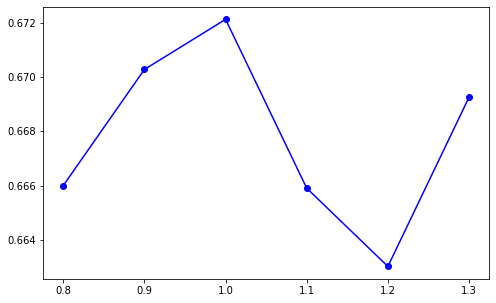

In [275]:
# 贪心调参
scores=[]
for i in np.arange(0.8,1.4,0.1):
    model=XGBClassifier(max_depth=7,#最大深度为3
                     learning_rate=0.1,#学习率为0.1
                     n_estimators=205,#初始设为500，利用xgboost的cv函数确定值
                     silent=False,
                     objective='binary:logistic',#二分类逻辑回归，输出为预测概率
                     booster='gbtree',#基学习器
                     n_jobs=-1,#最大可用线程数
                     gamma=0,#指定了节点分裂所需的最小损失函数下降值，值越大越保守
                     min_child_weight=5,#子节点最小权重和，低于则不再划分
                     subsample=0.8,#抽取数据的比例
                     colsample_bytree=0.8,#列采样比例，采样特征
                     reg_lambda=i,#正则化参数
                     seed=RANDOM_STATE)#随机种子
    modelfit=model.fit(X_train,y_train)
    predictions=modelfit.predict(X_test)
    scores.append(metrics.roc_auc_score(y_test,predictions))
    
plt.figure(figsize=(8,5))
plt.plot(np.arange(0.8,1.4,0.1),scores, 'bo-', label='lambda')
plt.show()